<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Okada inversion
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

# Package imports

In [1]:
%matplotlib notebook

import numpy as np

# import os
# from glob import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# from pyinsar.processing.utilities.generic import sorted_alphanumeric
# from pyinsar.data_import.import_raster import *
# from pyinsar.data_import.import_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.processing.deformation.elastic_halfspace import okada
from pyinsar.processing.deformation.inversion.quadtree import *
from pyinsar.processing.deformation.inversion.inversion import *
# from pyinsar.processing.utilities.generic import expand_nans
from pyinsar.processing.utilities.insar_simulator_utils import compute_los_vector
from pyinsar.output.plot_raster import *
# from pyinsar.output.export_georaster import *

# Setting

In [2]:
master_width = 1000
master_height = 1000

master_x_min = -20000. # m
master_x_max = 20000. # m
master_y_min = -20000. # m
master_y_max = 20000. # m

master_extent = (master_x_min/1000., master_x_max/1000., master_y_min/1000., master_y_max/1000.) # km

Let's define the simulation domain at the surface.

In [3]:
xx, yy = compute_x_and_y_coordinates_maps(master_x_min, master_x_max, 
                                          master_y_min, master_y_max, 
                                          master_width, master_height)

We can simulate faults and dikes using [Okada (1985)](https://pubs.geoscienceworld.org/ssa/bssa/article/75/4/1135/118782/surface-deformation-due-to-shear-and-tensile)'s model, which simulate the surface deformation for a rectangular dislocation.

In [4]:
%%time

fault_centroid_x = 0.
fault_centroid_y = 0.
fault_centroid_depth = 5500. # m

fault_strike = 200*np.pi/180. # rad
fault_dip = 10*np.pi/180. # rad
fault_length = 15000. # m
fault_width = 9000. # m
fault_rake = 90*np.pi/180. # rad
fault_slip = 1. # m
fault_open = 0. # m

poisson_ratio = 0.25

displacement = okada.compute_okada_displacement(fault_centroid_x,
                                                fault_centroid_y,
                                                fault_centroid_depth,
                                                fault_strike,
                                                fault_dip,
                                                fault_length,
                                                fault_width,
                                                fault_rake,
                                                fault_slip,
                                                fault_open,
                                                poisson_ratio,
                                                xx,
                                                yy)

CPU times: user 24 s, sys: 3.47 s, total: 27.5 s
Wall time: 1.76 s


Then we project the deformation along the line-of-sight of the satellite

In [5]:
incidence_angles = np.full((2, displacement.shape[-2], displacement.shape[-1]), 25.*np.pi/180.)
los_azimuths = np.full((2, displacement.shape[-2], displacement.shape[-1]), 190.*np.pi/180.)
los_azimuths[1] = 340.*np.pi/180.

In [6]:
los_vectors = compute_los_vector(incidence_angles, los_azimuths)
los_vectors = np.moveaxis(los_vectors, 0, 1)

In [7]:
los_displacements = np.empty((2, displacement.shape[-2], displacement.shape[-1]))
for i in range(los_vectors.shape[0]):
    los_displacements[i] = np.sum(displacement*los_vectors[i], axis = 0)

In [8]:
plot_interactive_multiple_slicing(los_displacements,
                                  [0],
                                  [0],
                                  update_colorbar = True,
                                  extent = master_extent,
                                  clabel = 'Displacement (m)',
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  figsize = (6, 5))

<IPython.core.display.Javascript object>

# Quadtree downsampling

In [9]:
%%time

variance_threshold = 0.000001
smallest_quadrant_size = 1000.
largest_quadrant_size = 5000.
use_variance_best_plane = True
use_median = False

downsampled_data = []
downsampled_coordinates = []
downsampled_los_vectors = []
unique_downsampled_coordinates = set()

for i in range(los_displacements.shape[0]):
    downsampled_datum = downsample_image_with_quadtree(los_displacements[i],
                                                       np.array([yy, xx]),
                                                       variance_threshold,
                                                       smallest_quadrant_size,
                                                       largest_quadrant_size,
                                                       use_variance_best_plane = use_variance_best_plane,
                                                       use_median = use_median)

    downsampled_datum = list(zip(*downsampled_datum))
    downsampled_data.append(downsampled_datum[2])
    downsampled_coordinate = list(zip(downsampled_datum[0], downsampled_datum[1]))
    downsampled_coordinates.append(downsampled_coordinate)

    downsampled_los_vector = get_closest_los_vector(np.array(downsampled_datum[1]),
                                                    np.array(downsampled_datum[0]),
                                                    los_vectors[i],
                                                    (master_x_min, master_x_max, master_y_min, master_y_max))
    downsampled_los_vectors.append(downsampled_los_vector)
    
    unique_downsampled_coordinates.update([tuple(row) for row in downsampled_coordinate])
    
unique_downsampled_coordinates = list(unique_downsampled_coordinates)

CPU times: user 22.5 s, sys: 697 ms, total: 23.2 s
Wall time: 7.43 s


In [10]:
for i in range(los_displacements.shape[0]):
    print(np.count_nonzero(~np.isnan(los_displacements[i])), len(downsampled_data[i]))

1000000 499
1000000 496


In [11]:
unique_downsampled_data = np.full((los_displacements.shape[0], len(unique_downsampled_coordinates)), np.nan)
unique_downsampled_los_vectors = np.full((los_displacements.shape[0], downsampled_los_vectors[0].shape[0], len(unique_downsampled_coordinates)), np.nan)

for i in range(len(unique_downsampled_coordinates)):
    for j in range(los_displacements.shape[0]):
        if unique_downsampled_coordinates[i] in downsampled_coordinates[j]:
            index = downsampled_coordinates[j].index(unique_downsampled_coordinates[i])
            unique_downsampled_data[j, i] = downsampled_data[j][index]
            unique_downsampled_los_vectors[j, :, i] = downsampled_los_vectors[j][:, index]
            
unique_downsampled_coordinates = np.array(unique_downsampled_coordinates)

In [12]:
index = 0

figure, subplot = plt.subplots(figsize = (9, 5))

scatter = plt.scatter(unique_downsampled_coordinates[:, 1],
                      unique_downsampled_coordinates[:, 0],
                      c = unique_downsampled_data[index],
                      s = 5, edgecolor = 'black', linewidth = 0.25, zorder = 1)

image_colorbar = plt.colorbar(scatter)
image_colorbar.set_label('Interferogram (cm)')

subplot.set_xlim(master_x_min, master_x_max)
subplot.set_ylim(master_y_min, master_y_max)
                
plt.show()

<IPython.core.display.Javascript object>

# Inversion

In [13]:
print('Fault centroid x:    ', fault_centroid_x)
print('Fault centroid y:    ', fault_centroid_y)
print('Fault centroid depth:', fault_centroid_depth)
print('Fault strike:        ', fault_strike)
print('Fault dip:           ', fault_dip)
print('Fault length:        ', fault_length)
print('Fault width:         ', fault_width)
print('Fault rake:          ', fault_rake)
print('Fault slip:          ', fault_slip)

Fault centroid x:     0.0
Fault centroid y:     0.0
Fault centroid depth: 5500.0
Fault strike:         3.490658503988659
Fault dip:            0.17453292519943295
Fault length:         15000.0
Fault width:          9000.0
Fault rake:           1.5707963267948966
Fault slip:           1.0


In [14]:
%%time

fault_centroid_x_initial_bounds = (5000., 5000.)
fault_centroid_y_initial_bounds = (5000., 5000.)
fault_centroid_depth_initial_bounds = (4000., 7500.)
fault_strike_initial_bounds = (200.*np.pi/180., 250.*np.pi/180.)
fault_dip_initial_bounds = (5.*np.pi/180., 20.*np.pi/180.)
fault_length_initial_bounds = (1000., 20000.)
fault_width_initial_bounds = (1000., 10000.)
fault_rake_initial_bounds = (86.*np.pi/180., 93.*np.pi/180.)
fault_slip_initial_bounds = (0.1, 2.)

number_restarts = 1000
number_chunks = 5

interferogram_weights = [1., 1.]

xtol = 0.0000000001
ftol = 0.0000000001
maxiter = None
maxfun = 10000

inversion_results = okada_inversion_with_parallel_monte_carlo_restarts(fault_centroid_x_initial_bounds,
                                                                       fault_centroid_y_initial_bounds,
                                                                       fault_centroid_depth_initial_bounds,
                                                                       fault_strike_initial_bounds,
                                                                       fault_dip_initial_bounds,
                                                                       fault_length_initial_bounds,
                                                                       fault_width_initial_bounds,
                                                                       fault_rake_initial_bounds,
                                                                       fault_slip_initial_bounds,
                                                                       0.,
                                                                       0.25,
                                                                       unique_downsampled_coordinates[:, 1],
                                                                       unique_downsampled_coordinates[:, 0],
                                                                       unique_downsampled_data,
                                                                       unique_downsampled_los_vectors,
                                                                       number_restarts,
                                                                       number_chunks,
                                                                       interferogram_weights = interferogram_weights,
                                                                       xtol = xtol,
                                                                       ftol = ftol,
                                                                       maxiter = maxiter,
                                                                       maxfun = maxfun,
                                                                       seed = 100)

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1595
         Function evaluations: 2463
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1646
         Function evaluations: 2540
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 1651
         Function evaluations: 2575
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2085
         Function evaluations: 3157
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2882
         Function evaluations: 4289
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1724
         Function evaluations: 2660
Optimization terminated successfully.
         Current function value: 0.042629
         Iterations: 1971
         Function evaluations: 3070
Optimi

         Function evaluations: 2907
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1534
         Function evaluations: 2389
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1949
         Function evaluations: 2966
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1947
         Function evaluations: 2962
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2036
         Function evaluations: 3055
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2421
         Function evaluations: 3603
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1569
         Function evaluations: 2398
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4930
      

/home/grongier/Packages/pyinsar-dev/pyinsar/processing/deformation/elastic_halfspace/okada.py:156: RuntimeWarning: divide by zero encountered in true_divide
  return y_tild*q/(R*(R + xi)) + math.cos(delta)*np.arctan(xi*eta/(q*R)) - I1(xi, eta, q, delta, nu, R, X, d_tild)*math.sin(delta)*math.cos(delta)
/home/grongier/Packages/pyinsar-dev/pyinsar/processing/deformation/elastic_halfspace/okada.py:168: RuntimeWarning: divide by zero encountered in true_divide
  return -d_tild*q/(R*(R + xi)) - math.sin(delta)*(xi*q/(R*(R + eta)) - np.arctan(xi*eta/(q*R))) - I1(xi, eta, q, delta, nu, R, X, d_tild)*math.sin(delta)**2
/home/grongier/Packages/pyinsar-dev/pyinsar/processing/deformation/elastic_halfspace/okada.py:275: RuntimeWarning: invalid value encountered in multiply
  + fault_open*chinnerys_notation(f_y_tensile, okada_x_array, p, q, fault_length, fault_width, fault_dip, poisson_ratio)/(2*np.pi)
/home/grongier/Packages/pyinsar-dev/pyinsar/processing/deformation/elastic_halfspace/okada.py:192

Optimization terminated successfully.
         Current function value: 0.060295
         Iterations: 1621
         Function evaluations: 2751
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2038
         Function evaluations: 3057
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2415
         Function evaluations: 3633
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2923
         Function evaluations: 4349
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1749
         Function evaluations: 2694
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 3655
         Function evaluations: 5416
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2514
         Function evaluations: 3741
Optimi

         Function evaluations: 2718
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2307
         Function evaluations: 3462
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2583
         Function evaluations: 3888
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3340
         Function evaluations: 4871
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3293
         Function evaluations: 4892
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1604
         Function evaluations: 2466
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1658
         Function evaluations: 2563
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 3471
      

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2397
         Function evaluations: 3591
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1433
         Function evaluations: 2234
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2287
         Function evaluations: 3448
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1957
         Function evaluations: 2952
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3106
         Function evaluations: 4560
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1826
         Function evaluations: 2760
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2083
         Function evaluations: 3143
Optimi

         Current function value: 0.000211
         Iterations: 2909
         Function evaluations: 4310
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2741
         Function evaluations: 4077
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1847
         Function evaluations: 2838
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1940
         Function evaluations: 2923
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4202
         Function evaluations: 6109
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2095
         Function evaluations: 3126
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3061
         Function evaluations: 4528
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1603
         Function evaluations: 2449
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1834
         Function evaluations: 2787
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3106
         Function evaluations: 4572
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1891
         Function evaluations: 2889
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2188
         Function evaluations: 3295
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4484
         Function evaluations: 6525
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1689
         Function evaluations: 2609
Optimi

         Function evaluations: 2871
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1700
         Function evaluations: 2596
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1705
         Function evaluations: 2614
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2863
         Function evaluations: 4278
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 1472
         Function evaluations: 2294
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2359
         Function evaluations: 3531
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2503
         Function evaluations: 3705
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2330
      

         Iterations: 4589
         Function evaluations: 6676
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2459
         Function evaluations: 3691
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2060
         Function evaluations: 3107
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1645
         Function evaluations: 2545
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 1417
         Function evaluations: 2219
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1968
         Function evaluations: 2959
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2082
         Function evaluations: 3130
Optimization terminated successfully.
         Current function value: 0.000211
      

         Current function value: 0.000211
         Iterations: 2191
         Function evaluations: 3336
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1503
         Function evaluations: 2289
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2460
         Function evaluations: 3704
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1879
         Function evaluations: 2872
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 2272
         Function evaluations: 3474
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1355
         Function evaluations: 2112
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1707
         Function evaluations: 2661
Optimization terminated successfully.
      

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1443
         Function evaluations: 2255
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 2040
         Function evaluations: 3124
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2798
         Function evaluations: 4137
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 1651
         Function evaluations: 2578
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2087
         Function evaluations: 3152
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1514
         Function evaluations: 2343
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1397
         Function evaluations: 2179
Optimi

         Iterations: 2163
         Function evaluations: 3242
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2516
         Function evaluations: 3767
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3666
         Function evaluations: 5379
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 4988
         Function evaluations: 7300
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2675
         Function evaluations: 3943
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2615
         Function evaluations: 3893
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1735
         Function evaluations: 2652
Optimization terminated successfully.
         Current function value: 0.000211
      

         Current function value: 0.016685
         Iterations: 3344
         Function evaluations: 4960
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4921
         Function evaluations: 7122
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2551
         Function evaluations: 3853
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3332
         Function evaluations: 4845
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1747
         Function evaluations: 2666
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1411
         Function evaluations: 2180
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4308
         Function evaluations: 6249
Optimization terminated successfully.
      

         Iterations: 1836
         Function evaluations: 2780
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1553
         Function evaluations: 2402
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2430
         Function evaluations: 3674
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2195
         Function evaluations: 3290
Optimization terminated successfully.
         Current function value: 0.016008
         Iterations: 1980
         Function evaluations: 3035
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1854
         Function evaluations: 2820
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4104
         Function evaluations: 5961
Optimization terminated successfully.
         Current function value: 0.000211
      

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2261
         Function evaluations: 3416
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2343
         Function evaluations: 3522
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2488
         Function evaluations: 3736
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2565
         Function evaluations: 3836
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 4565
         Function evaluations: 6659
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1810
         Function evaluations: 2772
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1973
         Function evaluations: 2973
Optimi

         Current function value: 0.000211
         Iterations: 1754
         Function evaluations: 2649
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2895
         Function evaluations: 4253
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1724
         Function evaluations: 2627
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 1413
         Function evaluations: 2225
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1972
         Function evaluations: 2985
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2189
         Function evaluations: 3309
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2588
         Function evaluations: 3885
Optimization terminated successfully.
      

         Iterations: 2934
         Function evaluations: 4328
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 1331
         Function evaluations: 2107
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1927
         Function evaluations: 2932
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 4256
         Function evaluations: 6232
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2170
         Function evaluations: 3287
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 3745
         Function evaluations: 5427
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2090
         Function evaluations: 3126
Optimization terminated successfully.
         Current function value: 0.000211
      

         Current function value: 0.049125
         Iterations: 3889
         Function evaluations: 5852
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2025
         Function evaluations: 3088
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2331
         Function evaluations: 3518
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2352
         Function evaluations: 3513
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 2311
         Function evaluations: 3460
Optimization terminated successfully.
         Current function value: 0.016685
         Iterations: 6249
         Function evaluations: 9069
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 1712
         Function evaluations: 2620
Optimization terminated successfully.
      

In [15]:
print('Fault centroid x:    ', fault_centroid_x, '-', inversion_results[0][0])
print('Fault centroid y:    ', fault_centroid_y, '-', inversion_results[0][1])
print('Fault centroid depth:', fault_centroid_depth, '-', inversion_results[0][2])
print('Fault strike:        ', fault_strike, '-', inversion_results[0][3])
print('Fault dip:           ', fault_dip, '-', inversion_results[0][4])
print('Fault length:        ', fault_length, '-', inversion_results[0][5])
print('Fault width:         ', fault_width, '-', inversion_results[0][6])
print('Fault rake:          ', fault_rake, '-', inversion_results[0][7])
print('Fault slip:          ', fault_slip, '-', inversion_results[0][8])
print('Final misfit:        ', inversion_results[1])

Fault centroid x:     0.0 - 2.2055119658656164
Fault centroid y:     0.0 - 1.5239237071741156
Fault centroid depth: 5500.0 - 5520.159473898002
Fault strike:         3.490658503988659 - 3.490263021425752
Fault dip:            0.17453292519943295 - 0.17497812739190116
Fault length:         15000.0 - 14992.93872653864
Fault width:          9000.0 - 9006.39731097447
Fault rake:           1.5707963267948966 - 1.5697795027802006
Fault slip:           1.0 - 0.9991671316363322
Final misfit:         0.0002110820958383256


In [16]:
%%time

inverted_displacement = okada.compute_okada_displacement(inversion_results[0][0],
                                                         inversion_results[0][1],
                                                         inversion_results[0][2],
                                                         inversion_results[0][3],
                                                         inversion_results[0][4],
                                                         inversion_results[0][5],
                                                         inversion_results[0][6],
                                                         inversion_results[0][7],
                                                         inversion_results[0][8],
                                                         fault_open,
                                                         poisson_ratio,
                                                         xx,
                                                         yy)
inverted_los_displacements = np.empty((2, inverted_displacement.shape[-2], inverted_displacement.shape[-1]))
for i in range(los_vectors.shape[0]):
    inverted_los_displacements[i] = np.sum(inverted_displacement*los_vectors[i], axis = 0)

CPU times: user 31.6 s, sys: 6.65 s, total: 38.3 s
Wall time: 2.4 s


<IPython.core.display.Javascript object>


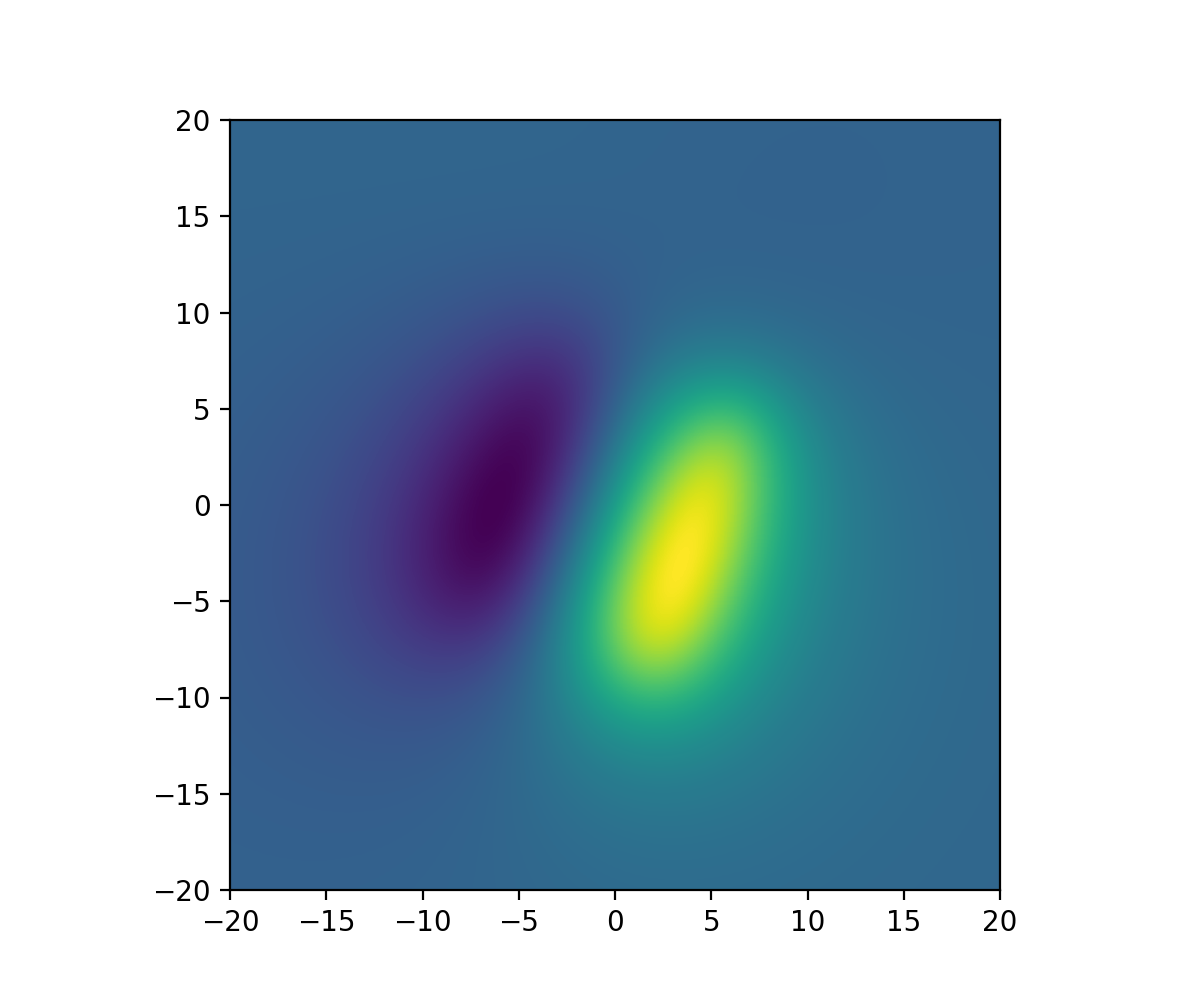

NameError: name 'compute_fault_projection_corners' is not defined

In [17]:
figure, subplot = plt.subplots(figsize = (6, 5))

image = plt.imshow(np.ma.masked_invalid(inverted_los_displacements[0]), extent = master_extent,
                   cmap = 'viridis', interpolation = 'None', rasterized = True,
                   zorder = 0)

fault_projection_corners = compute_fault_projection_corners(fault_centroid_x/1000.,
                                                            fault_centroid_y/1000.,
                                                            fault_strike,
                                                            fault_dip,
                                                            fault_length/1000.,
                                                            fault_width/1000.)
fault = Polygon(fault_projection_corners, fill = False, edgecolor = 'gray')
subplot.add_patch(fault)
plt.scatter(fault_centroid_x/1000., fault_centroid_y/1000., c = 'gray', zorder = 1)

fault_projection_corners = compute_fault_projection_corners(inversion_results[0][0]/1000.,
                                                            inversion_results[0][1]/1000.,
                                                            inversion_results[0][3],
                                                            inversion_results[0][4],
                                                            inversion_results[0][5]/1000.,
                                                            inversion_results[0][6]/1000.)
fault = Polygon(fault_projection_corners, fill = False, edgecolor = 'red')
subplot.add_patch(fault)
plt.scatter(inversion_results[0][0]/1000., inversion_results[0][1]/1000., c = 'red', zorder = 1)

image_colorbar = plt.colorbar(image)
image_colorbar.set_label('Displacement (m)')
                
plt.show()

In [ ]:
plot_interactive_multiple_slicing(los_displacements - inverted_los_displacements,
                                  [0],
                                  [0],
                                  update_colorbar = True,
                                  extent = master_extent,
                                  clabel = 'Displacement (m)',
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  figsize = (6, 5))